In [2]:
import numpy as np
import timeit

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

## Part 1: Michaelis-Menten Equation

In [14]:
kms = [1, 0.5, 1]
vmaxs = [25, 25, 15]
srange = np.linspace(0, 10, 1000)

plot_colours = ["darkred", "blue", "darkgreen"]

In [30]:
def plot_v_vs_s(ax, srange: np.ndarray, km: float, vmax: float, col="blue"):
    # Reaction rate (y-axis) values
    vv = vmax * (srange / (srange + km))

    # Plot the smooth line
    ax.plot(srange, vv, color=col, label=f'$K_m={km}, V_{{max}}={vmax}$', lw=2.5)

    # Plot horizontal dotted lines at 0.5*vmax and vmax
    ax.hlines(vmax, srange[0], srange[-1], linestyles="dashed")
    ax.hlines(0.5 * vmax, srange[0], km, linestyles="dotted")

    # Add 0.5*vmax, vmax y-ticks
    yticks = [*ax.get_yticks(), 0.5 * vmax, vmax]
    yticklabels = [*ax.get_yticklabels(), r"$0.5 V_{\max}$ = " + f"{0.5*vmax}", r"$V_{\max}$ = " + f"{vmax}"]
    ax.set_yticks(yticks, labels=yticklabels)

    # # Change colours of 0.5*vmax, vmax y-ticks
    # I REGRET MY DECISIONS
    # vind = np.where(ax.get_yticks() == 0.5*vmax)[0][0]
    # ax.yaxis.get_ticklabels()[vind].set_color(col)
    # vind = np.where(ax.get_yticks() == vmax)[0][0]
    # ax.yaxis.get_ticklabels()[vind].set_color(col)
    
    # Plot vertical dotted lines at km
    ax.vlines(km, vv[0], 0.5 * vmax, linestyles="dotted")

    # Add km x-tick
    xticks = [*ax.get_xticks(), km]
    xticklabels = [*ax.get_xticklabels(), r"$K_m = $" + f"{km}"]
    ax.set_xticks(xticks, labels=xticklabels)

    # # Change colour of km x-tick
    # vind = np.where(ax.get_xticks() == km)[0][0]
    # ax.xaxis.get_ticklabels()[vind].set_color(col)

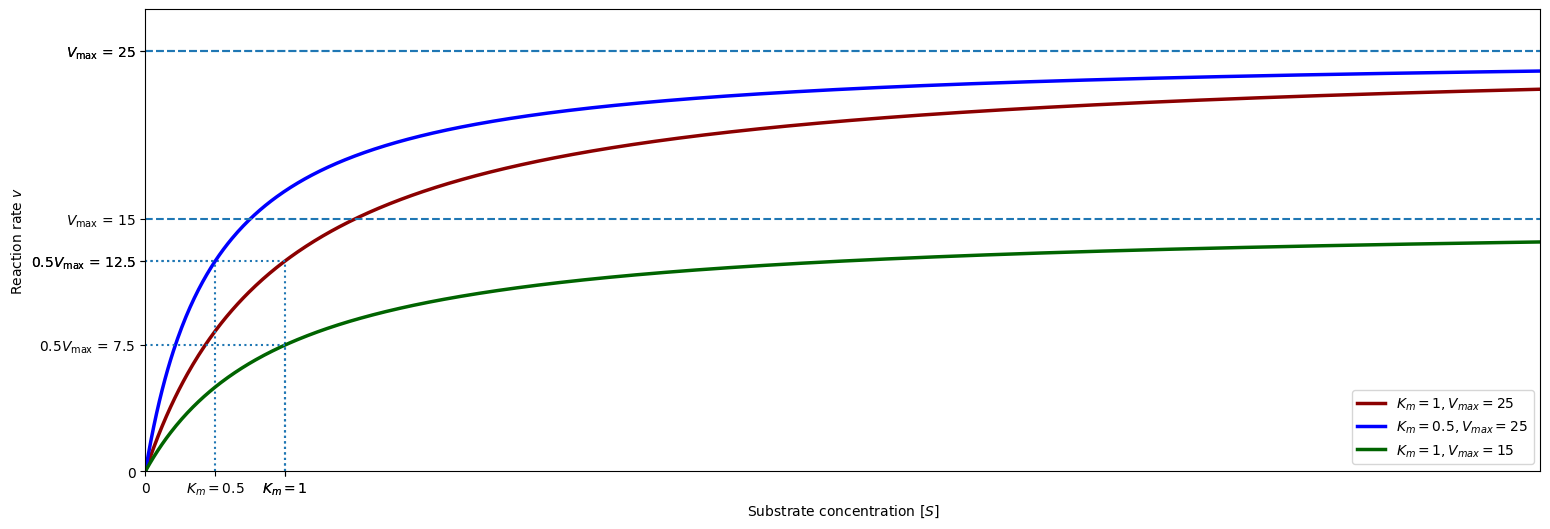

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ax.set_xticks([0])
ax.set_yticks([0])
ax.set_xlim((srange[0], srange[-1]))
ax.set_ylim((0, max(vmaxs) * 1.1))

ax.set_xlabel("Substrate concentration " + r"$[S]$")
ax.set_ylabel("Reaction rate " + r"$v$")

for (km, vmax, pc) in zip(kms, vmaxs, plot_colours):
    plot_v_vs_s(ax, srange, km, vmax, col=pc)

ax.legend(loc="lower right")
plt.show()

The red plot shows resulting reaction rate $v$ plotted against substrate concentration $[S]$ for $K_m = 1$ and $V_{\max} = 25$. 

The reaction occurs faster (rate grows) when substrate is added to the system. Rate grows the quicker, the less substrate there already is in the system. Once substrate concentration $[S]$ reaches the level of Michaelis constant $K_m$, the reaction rate $v$ is $50\%$ of the maximum $V_{\max}$. 

When there already is a lot of substrate in the system ($[S]$ is large), the reaction rate $v$ grows very slowly. This is because the problem then becomes the insufficient amount of enzyme, rather than substrate. There is not many enzyme molecules left to bind with the substrates and create $ES$ complexes. The system becomes saturated.

When $K_m$ is lowered to $0.5$ (blue line), the initial growth of $v$ becomes faster. Reaction rate $v$ reaches $50\% V_{\max}$ more quickly. Since $V_{\max}$ is kept constant, the gap between the red and blue lines becomes $0$ in the limit of large $[S]$.

When $V_{\max}$ is lowered to $15$ (green line), the initial and overall growth of $v$ becomes sloewr. Reaction rate $v$ reaches $50\% V_{\max}$ at the same substrate concentration, but this value is now lower. The catalytic reaction will occur more gradually as compared with the experiment with $V_{\max} = 25$.

## Part 2: Lineweaver-Burk

### a) Plotting data & retrieving parameters with `curve_fit()`

In [24]:
data = np.loadtxt("data/Data/measuredData.csv", delimiter=",").T

ss = data[0]
vv = data[1]

In [26]:
def michaelis_menten_equation(s, vmax, km):
    return vmax * (s / (s + km))

popt, _ = curve_fit(michaelis_menten_equation, ss, vv)
vmax, km = popt

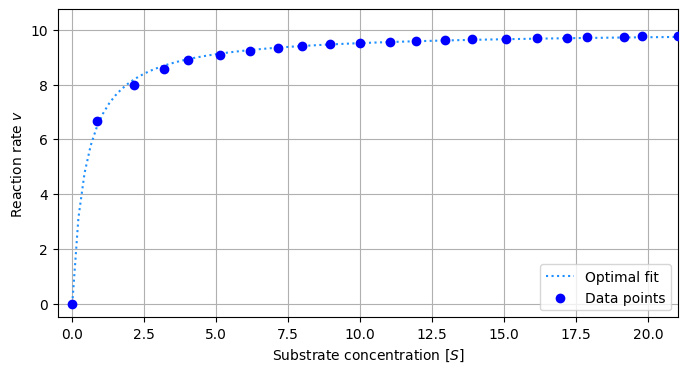

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_xlim((-0.5, max(ss)))
ax.set_ylim((-0.5, 1.1*max(vv)))

ax.set_xlabel("Substrate concentration " + r"$[S]$")
ax.set_ylabel("Reaction rate " + r"$v$")

ax.grid()


xxopt = np.linspace(min(ss), max(ss), 100)
ax.plot(xxopt, michaelis_menten_equation(xxopt, vmax, km), ls="dotted",  color="dodgerblue", label="Optimal fit")

ax.scatter(ss, vv, color="blue", label="Data points", zorder=10)

ax.legend(loc="lower right")

plt.show()